In [6]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import torch
from numpy.linalg import LinAlgError
import seaborn as sns

In [7]:
def moore_penrose_pseudoinv(X):
    return np.linalg.inv(X.T @ X) @ X.T


def W_alpha_task(X_s, X_q, alpha):
    assert (X_s.shape == X_q.shape)
    n = X_s.shape[0]
    p = X_s.shape[1]
    return (np.eye(p) - (alpha/n) * X_s.T @ X_s) @ X_q.T
    
    
def Z_alpha_task(X_s, y_s, X_q, y_q, alpha):
    assert (X_s.shape == X_q.shape)
    assert (y_s.shape == y_q.shape)
    n = X_s.shape[0]
    return y_q - (alpha/n) * X_q @ (X_s.T @ y_s)


def grad_task(X_s, y_s, theta):
    n = X_s.shape[0]
    return (1./n) * ((X_s.T @ X_s) @ theta - X_s.T @ y_s)


def adapt_task(X_s, y_s, theta, alpha):
    return theta - alpha * grad_task(X_s, y_s, theta)

In [18]:
def sample_task(n, p, X_s_fixed=None):
    
    theta_t = np.random.uniform(theta_t_min, theta_t_max)
    max_task_eig_val = np.random.uniform(1, max_meta_eig_val)
    eig_val = np.random.uniform(1., max_task_eig_val, size=(p))
    Q_t = V_t @ np.diag(eig_val) @ V_t.T
    sigma_t = np.random.uniform(0, np.sqrt(1))
    
    # support    
    X_s = np.stack([np.random.multivariate_normal(mean=np.zeros(p), cov=Q_t) for _ in range(n)])
    y_s = (X_s @ theta_t) + np.random.normal(size=(n)) * sigma_t
    if X_s_fixed is not None:
        y_s_fixml = (X_s_fixed @ theta_t) + np.random.normal(size=(n)) * sigma_t
    else:
        y_s_fixml = None
        
    # query
    X_q = np.stack([np.random.multivariate_normal(mean=np.zeros(p), cov=Q_t) for _ in range(n)])
    y_q = (X_q @ theta_t) + np.random.normal(size=(n)) * sigma_t
    
    return X_s, y_s, X_q, y_q, theta_t, y_s_fixml



def evaluate_theta_over_multiple_tasks(theta_hat_ML, theta_hat_fixML, alpha, n, X_s_fixed, opt_wt=None):
    p = len(theta_hat_ML)
    assert len(theta_hat_fixML) == p
    
    m = 2000
    risk_ML = []
    risk_fixML = []
    risk_fixML_usingFixS = []
    risk_opt_wt = []
    
    for _ in range(m):
        X_s, y_s, X_q, y_q, _, y_s_fixml = sample_task(n, p, X_s_fixed)
        theta_hat_t_ML = adapt_task(X_s, y_s, theta_hat_ML, alpha)
        theta_hat_t_fixML = adapt_task(X_s, y_s, theta_hat_fixML, alpha)
        theta_hat_t_fixML_usingFixS = adapt_task(X_s_fixed, y_s_fixml, theta_hat_fixML, alpha)
        
        risk_ML.append(np.mean((X_q @ theta_hat_t_ML - y_q)**2))
        risk_fixML.append(np.mean((X_q @ theta_hat_t_fixML - y_q)**2))
        risk_fixML_usingFixS.append(np.mean((X_q @ theta_hat_t_fixML_usingFixS  - y_q)**2))
        if opt_wt is not None:
            theta_hat_t_opt_wt = adapt_task(X_s, y_s, opt_wt, alpha)
            risk_opt_wt.append(np.mean((X_q @ theta_hat_t_opt_wt  - y_q)**2))
    
    return np.mean(risk_ML), np.mean(risk_fixML), np.mean(risk_fixML_usingFixS), np.mean(risk_opt_wt) if opt_wt is not None else None

In [19]:
def main(n_runs, n, p, alpha, m):

    runs_ML = []
    runs_fixML = []
    runs_fixML_usingFixS = []
    l2_diffs_ML_fixML = []
    l2_diffs_ML_opt = []
    l2_diffs_fixML_opt = []
    
    for _ in tqdm(range(n_runs)):
        
        # set seed
        seed = np.random.choice(100)
        np.random.seed(seed)
        
        # fix support for fix ML
        X_s_fixed=sample_task(n, p)[0]
        
        # init
        W_alpha_ML = []
        Z_alpha_ML = []
        W_alpha_fixML = []
        Z_alpha_fixML = []
        
        # iterate over tasks
        for _ in range(m):
            X_s, y_s, X_q, y_q, _, y_s_fixml = sample_task(n, p, X_s_fixed=X_s_fixed)
            W_alpha_ML.append(W_alpha_task(X_s, X_q, alpha).T)
            Z_alpha_ML.append(Z_alpha_task(X_s, y_s, X_q, y_q, alpha))
            W_alpha_fixML.append(W_alpha_task(X_s_fixed, X_q, alpha).T)
            Z_alpha_fixML.append(Z_alpha_task(X_s_fixed, y_s_fixml, X_q, y_q, alpha))
        
        # estimates
        W_alpha_ML = np.concatenate(W_alpha_ML, axis=0)
        Z_alpha_ML = np.concatenate(Z_alpha_ML, axis=0)
        W_alpha_fixML = np.concatenate(W_alpha_fixML, axis=0)
        Z_alpha_fixML = np.concatenate(Z_alpha_fixML, axis=0)
        argmin_ML_empirical = moore_penrose_pseudoinv(W_alpha_ML) @ Z_alpha_ML
        argmin_fixML_empirical = moore_penrose_pseudoinv(W_alpha_fixML) @ Z_alpha_fixML
        
        # evaluation
        ML_test_loss, fixML_test_loss, fixML_test_loss_usingFixS, opt_wt_test_loss = evaluate_theta_over_multiple_tasks(
                    theta_hat_ML=argmin_ML_empirical, theta_hat_fixML=argmin_fixML_empirical,
                    alpha=alpha, n=n, X_s_fixed=X_s_fixed, opt_wt=opt_wt)
        l2_diff_ML_opt = np.linalg.norm(argmin_ML_empirical - opt_wt)
        l2_diff_fixML_opt = np.linalg.norm(argmin_fixML_empirical - opt_wt)
        
        runs_ML.append(ML_test_loss)
        runs_fixML.append(fixML_test_loss)
        runs_fixML_usingFixS.append(fixML_test_loss_usingFixS)
        
        l2_diffs_ML_fixML.append(np.linalg.norm(argmin_fixML_empirical - argmin_ML_empirical))
        l2_diffs_ML_opt.append(np.linalg.norm(argmin_ML_empirical - opt_wt))
        l2_diffs_fixML_opt.append(np.linalg.norm(argmin_fixML_empirical - opt_wt))
        
    
    return runs_ML, runs_fixML, runs_fixML_usingFixS, l2_diffs_ML_fixML, l2_diffs_ML_opt, l2_diffs_fixML_opt

In [20]:
# set seed
seed = 90
np.random.seed(seed)

alpha = 0.5 # inner loop lr
m=25 # M is no. of tasks to sample
n=5 # n is no. of support/query samples in a task
p=25 # p is ambient dimension
V_t = np.stack([np.random.normal(size=(p)) for _ in range(p)], axis=0).T
V_t = np.linalg.qr(V_t)[0]
max_meta_eig_val = 5.
theta_t_min = np.zeros(p)
theta_t_max = np.random.uniform(0., 1., size=p)
opt_wt = (theta_t_min + theta_t_max) / 2. # mean of uniform distribution

print(f"n={n}_p={p}_alpha={alpha}_m={m}_seed={seed}")

        
# fix support for fix ML
X_s_fixed=sample_task(n, p)[0]
        
# init
W_alpha_ML = []
Z_alpha_ML = []
W_alpha_fixML = []
Z_alpha_fixML = []

# iterate over tasks
for _ in range(m):
    X_s, y_s, X_q, y_q, _, y_s_fixml = sample_task(n, p, X_s_fixed=X_s_fixed)
    W_alpha_ML.append(W_alpha_task(X_s, X_q, alpha).T)
    Z_alpha_ML.append(Z_alpha_task(X_s, y_s, X_q, y_q, alpha))
    W_alpha_fixML.append(W_alpha_task(X_s_fixed, X_q, alpha).T)
    Z_alpha_fixML.append(Z_alpha_task(X_s_fixed, y_s_fixml, X_q, y_q, alpha))
        
# estimates
W_alpha_ML = np.concatenate(W_alpha_ML, axis=0)
Z_alpha_ML = np.concatenate(Z_alpha_ML, axis=0)
W_alpha_fixML = np.concatenate(W_alpha_fixML, axis=0)
Z_alpha_fixML = np.concatenate(Z_alpha_fixML, axis=0)
argmin_ML_empirical = moore_penrose_pseudoinv(W_alpha_ML) @ Z_alpha_ML
argmin_fixML_empirical = moore_penrose_pseudoinv(W_alpha_fixML) @ Z_alpha_fixML

# evaluation
ML_test_loss, fixML_test_loss, fixML_test_loss_usingFixS, opt_wt_test_loss = evaluate_theta_over_multiple_tasks(
            theta_hat_ML=argmin_ML_empirical, theta_hat_fixML=argmin_fixML_empirical,
            alpha=alpha, n=n, X_s_fixed=X_s_fixed, opt_wt=opt_wt)
l2_diff_ML_opt = np.linalg.norm(argmin_ML_empirical - opt_wt)
l2_diff_fixML_opt = np.linalg.norm(argmin_fixML_empirical - opt_wt)

    
print("ml: ", ML_test_loss)
print("fixml: ", fixML_test_loss)
print("fixml (using fixS): ", fixML_test_loss_usingFixS)
print("opt wt: ", opt_wt_test_loss)
print("euc norm diff (ml - opt)", l2_diff_ML_opt)
print("euc norm diff (fixml - opt)", l2_diff_fixML_opt)

n=5_p=25_alpha=0.5_m=25_seed=90
ml:  19.99066123345126
fixml:  30.28152286905588
fixml (using fixS):  14.823681162200224
opt wt:  14.017404671247998
euc norm diff (ml - opt) 0.6342813494095385
euc norm diff (fixml - opt) 1.05292507221925


## n_runs=100
seed = np.random.choice(100)
alpha = 0.1 # inner loop lr
M=[500, 5000, 50000] # no. of tasks to sample
n=5 # n is no. of support/query samples in a task
p=25 # p is ambient dimension
V_t = np.stack([np.random.normal(size=(p)) for _ in range(p)], axis=0).T
V_t = np.linalg.qr(V_t)[0]
max_meta_eig_val = 20.
theta_t_min = np.zeros(p)
theta_t_max = np.random.uniform(0., 2., size=p)
opt_wt = (theta_t_min + theta_t_max) / 2. # mean of uniform distribution

for m in M:
    exp_name = f"n={n}_p={p}_alpha={alpha}_m={m}_seed={seed}"
    print(f"exp: {exp_name}")
    
    runs_ML, runs_fixML, runs_fixML_usingFixS, l2_diffs_ML_fixML, l2_diffs_ML_opt, l2_diffs_fixML_opt=main(
        m=m, n=n, p=p, alpha=alpha, n_runs=n_runs)
    
    # test loss
    fig = plt.figure()
    sns.distplot(runs_ML, label='ML mean %.2f std %.2f' % (np.mean(runs_ML), np.std(runs_ML)))
    sns.distplot(runs_fixML, label='FixML mean %.2f std %.2f' % (np.mean(runs_fixML), np.std(runs_fixML)))
    sns.distplot(runs_fixML_usingFixS, label='FixML using FixS mean %.2f std %.2f' % (np.mean(runs_fixML_usingFixS), np.std(runs_fixML_usingFixS)))
    plt.title(f"{exp_name}")
    plt.legend()
    plt.savefig(f"meta-linear-regression-results/test_loss_{exp_name}.png")
    
    # est error
    fig = plt.figure()
    sns.distplot(l2_diffs_ML_opt, label='ML mean %.2f std %.2f' % (np.mean(l2_diffs_ML_opt), np.std(l2_diffs_ML_opt)))
    sns.distplot(l2_diffs_fixML_opt, label='FixML mean %.2f std %.2f' % (np.mean(l2_diffs_fixML_opt), np.std(l2_diffs_fixML_opt)))
    plt.title(f"{exp_name}")
    plt.legend()
    plt.savefig(f"meta-linear-regression-results/est_error_{exp_name}.png")

In [25]:
prev = [
49.46,
50.78,
50.83,
50.78,
51.12,
49.46,
51.26,
50.44,
49.89,
50.50,
51.46,
51.11,
51.63,
50.76,
49.95,
50.47,
50.22,
50.57,
49.73,
51.37,
53.14,
52.66,
52.92,
53.58,
53.45,
54.02,
53.85,
53.91,
53.65,
53.70,
54.26,
53.02,
53.35,
53.55,
52.41,
51.29,
51.95,
52.29,
51.66,
51.11,
52.69,
52.07,
52.14,
51.85,
51.53,
52.31,
52.10,
52.02,
52.12,
51.45,
52.03,
51.87,
51.73,
51.64,
51.51,
51.18,
51.40,
51.29,
51.41,
50.96,
50.96
]

new = [
    49.69,
52.18,
51.56,
51.63,
49.69,
51.23,
51.95,
50.89,
51.15,
51.03,
50.18,
51.30,
49.83,
50.49,
50.32,
51.55,
49.09,
51.41,
51.21,
48.61,
53.90,
53.98,
53.80,
53.07,
52.83,
52.07,
52.14,
51.07,
51.77,
50.19,
51.51,
49.87,
50.53,
49.59,
50.32,
49.73,
50.41,
49.05,
49.72,
50.55,
50.79,
50.20,
48.99,
49.42,
49.18,
49.64,
49.38,
50.14,
48.98,
49.10,
49.56,
49.17,
48.59,
48.40,
49.34,
49.56,
49.18,
48.65,
48.74,
]

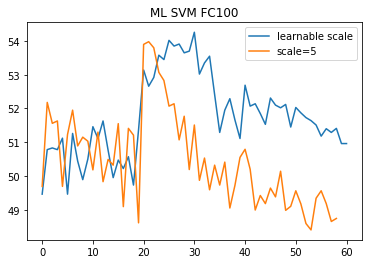

In [29]:
plt.plot(prev, label='learnable scale')
plt.plot(new, label='scale=5')
plt.legend()
plt.title("ML SVM FC100")
plt.show()